# Data processing

In [19]:
import csv
import ijson
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt


In [3]:
from helpers import count_upper_and_excl, count_neg_emojis, count_neg_words, sentiment, extract_features

LookupError: 
**********************************************************************
  Resource [93mvader_lexicon[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('vader_lexicon')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93msentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt[0m

  Searched in:
    - '/Users/matteopeduto/nltk_data'
    - '/Users/matteopeduto/opt/anaconda3/envs/ada/nltk_data'
    - '/Users/matteopeduto/opt/anaconda3/envs/ada/share/nltk_data'
    - '/Users/matteopeduto/opt/anaconda3/envs/ada/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


The file `yt_metadata_en.jsonl.gz` should be unzipped (~ 98 Go) in the data directory. 

In [ ]:
data_path = 'data/'

### Process the big json file to small CSVs (one for each year) and then parquet

Store the columns we need in `yt_metadata_en.jsonl` (all but `title`, `tags`, `description`) in a separate CSV file for each year

In [ ]:
# Years from 2005 to 2019 (included)

#years = [str(year) for year in range(2005, 2020)]
years = ['2019'] # We only use 2019 at the moment, for simplicity.

In [ ]:
# Create CSVs with only the columns to keep (drop title, description and tags)

f = open(data_path + 'yt_metadata_en.jsonl')
videos = ijson.items(f, '', multiple_values=True)

output = {year: open(f'generated/{year}/{year}_videos_few_columns.csv', 'w') for year in years}

columns_to_drop = [
    'description', 
    'tags', 
    'title'
]
columns_to_keep = [
    'categories', 
    'channel_id', 
    'crawl_date', 
    'dislike_count', 
    'display_id', 
    'duration', 
    'like_count',
    'upload_date',
    'view_count'

]
columns = [f'"{str(col)}"' for col in columns_to_keep]

# Write the headers in neach CSV
for year in years:
    output[year].write(','.join(columns))
    output[year].write('\n')

# Put each video from the json file in the CSV with the correct year
for video in tqdm(videos):
    data_to_write = [str(video[field]) for field in columns_to_keep]
    date_video = str(video['upload_date'])
    year_video = date_video[:4]
    
    written = False
    for year in years:
        if year == year_video:
            output[year].write(','.join(data_to_write))
            output[year].write('\n')
            written = True
            break
    
print('Finished') # 9min50s
for year in years:
    output[year].close()
f.close()

In [ ]:
%%time
# Convert each CSV file to a parquet file (faster to read)
types_col = {    
    'categories': 'string', 
    'channel_id': 'string', 
    'dislike_count': 'Int32',
    'display_id': 'string', 
    'duration': 'string', 
    'like_count': 'Int64',
    'view_count': 'Int64'
}
for year in tqdm(years):
    v = pd.read_csv(
        f'generated/{year}/{year}_videos_few_columns.csv', 
        sep=',', 
        header=0, 
        dtype=types_col, 
        parse_dates=['crawl_date', 'upload_date'],
        na_values=['None'],
        engine='c'
    ) # 6min36s [[Djian: It might be faster using pyarrow csv]]
    v.to_parquet(f'generated/{year}/{year}_videos_few_columns.parquet', compression=None)

In [ ]:
df_videos = {
    year: pd.read_parquet(f'generated/{year}/{year}_videos_few_columns.parquet', engine='fastparquet') 
    for year in years
}

### Split the big json into CSV files (one for each year, keeping all columns)

In [ ]:
# Create CSVs that split the big json file into years

f = open(data_path + 'yt_metadata_en.jsonl')
videos = ijson.items(f, '', multiple_values=True)

output = {year: open(f'generated/{year}/{year}_videos.csv', 'w') for year in years}

columns_to_drop = [
    'description', 
    'tags', 
    'title'
]
columns_to_keep = [
    'categories', 
    'channel_id', 
    'crawl_date', 
    'dislike_count', 
    'display_id', 
    'duration', 
    'like_count',
    'upload_date',
    'view_count'

]

columns = columns_to_keep + columns_to_drop

writer = {year: csv.DictWriter(output[year], fieldnames=columns) for year in years}

for year in years:
    writer[year].writeheader()

# Put each video from the json file in the CSV with the correct year
for video in tqdm(videos):
    data_to_write = [str(video[field]) for field in columns_to_keep + columns_to_drop]
    date_video = str(video['upload_date'])
    year_video = date_video[:4]
    
    written = False
    for year in years:
        if year == year_video:
            writer[year].writerow(video)
    
    
print('Finished') # 9min50s
for year in years:
    output[year].close()
f.close()

### Extract the features

In [ ]:
features = [] # to be filled

#### Count uppercase words and exclamation marks

In [ ]:
# Count in titles in 2019
df_typography_title = extract_features(text_to_features=count_upper_and_excl, year='2019', field='title')
features.append(df_typography_title)

In [ ]:
# Count in descriptions in 2019
df_typography_desc = extract_features(text_to_features=count_upper_and_excl, year='2019', field='description')
features.append(df_typography_desc)

#### Count negative emojis

In [ ]:
# Count in titles in 2019
df_emojis_title = extract_features(text_to_features=count_neg_emojis, year='2019', field='title')
features.append(df_emojis_title)

In [ ]:
# Count in descriptions in 2019
df_emojis_desc = extract_features(text_to_features=count_neg_emojis, year='2019', field='description')
features.append(df_emojis_desc)

#### Count negative words

In [ ]:
# Count in titles in 2019
df_neg_words_title = extract_features(text_to_features=count_neg_words, year='2019', field='title') # 3min22s
features.append(df_neg_words_title)

In [ ]:
# Count in descriptions in 2019
df_neg_words_desc = extract_features(text_to_features=count_neg_words, year='2019', field='description') # 6min30s
features.append(df_neg_words_desc)

#### Compute sentiment analysis

In [ ]:
# Sentiment on titles in 2019
df_sia_title = extract_features(text_to_features=sentiment, year='2019', field='title') # 20min
features.append(df_sia_title)

In [ ]:
# Sentiment on descriptions in 2019
#df_sia_desc = extract_features(text_to_features=sentiment, year='2019', field='description') # ~3h (projection) 
#features.append(df_sia_desc)

#### Join the dataframes and store the results

In [ ]:
# Join all the dataframes of features
df_features = features[0]
for i in range(1, len(features)):
    df_features = df_features.join(features[i])

In [ ]:
# Read the df of videos from 2019 (without titles, tags and descriptions, to have a small file)
videos_few_cols = pd.read_parquet('generated/2019/2019_videos_few_columns.parquet', engine='fastparquet')

In [ ]:
# Join the features to the videos
videos_features = videos_few_cols.join(df_features)

In [ ]:
# Store the df videos with features to a parquet file
videos_features.to_parquet(f'generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment.parquet', compression=None) # 3s

#### How to load the dataframe with videos and features (from 2019)

In [3]:
# Run:
videos_features = pd.read_parquet('generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment.parquet', engine='fastparquet')

In [6]:
videos_features

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,count_words_title,...,sia_negative_title,sia_neutral_title,sia_positive_title,sia_compound_title,count_negative_emojis_title,count_upper_words_title,count_excl_marks_title,count_upper_words_description,count_excl_marks_description,count_negative_emojis_description
0,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:57.427254,35,JOeSxtcNdHQ,8620,1673,2019-10-01,48737,6,...,0.0,1.000,0.000,0.0000,0,0,0,2,0,0
1,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.108323,15,EPMLTw2zINw,355,1297,2019-10-01,19999,2,...,0.0,1.000,0.000,0.0000,0,0,0,0,0,0
2,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.773085,78,Y1_pK68iSYQ,603,3305,2019-09-28,58518,10,...,0.0,0.734,0.266,0.4404,0,0,0,2,0,0
3,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:59.465346,70,jF8TSo3ZfTc,1426,1889,2019-09-21,71998,16,...,0.0,1.000,0.000,0.0000,0,1,0,10,0,0
4,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:40:00.188768,73,Gp00dNaVouo,990,2699,2019-09-14,101924,10,...,0.0,1.000,0.000,0.0000,0,0,0,15,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12723119,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:51.649137,0,9pJ89IFoWbY,87,4,2019-08-06,158,12,...,0.0,0.597,0.403,0.5267,0,1,0,1,1,0
12723120,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:44.519636,1,YB1fBzL6RWs,58,27,2019-08-06,669,13,...,0.0,0.649,0.351,0.5267,0,0,0,0,1,0
12723121,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:46.890669,1,Y9eUxJBHFpc,77,4,2019-08-06,263,13,...,0.0,0.649,0.351,0.5267,0,0,0,0,1,0
12723122,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:49.212538,0,cR45-7Tg0WU,106,4,2019-08-06,123,12,...,0.0,0.625,0.375,0.5267,0,0,0,0,1,0


In [28]:
ratio_neg_words_title = videos_features['count_negative_words_title']/videos_features['count_words_title']
ratio_neg_words_description = videos_features['count_negative_words_description']/videos_features['count_words_description']


type_neg_desc = ['description']*len(ratio_neg_words_description)
type_neg_title = ['title']*len(ratio_neg_words_title)
type_neg = np.concatenate((type_neg_desc, type_neg_title), None)
neg_words = np.concatenate((ratio_neg_words_description, ratio_neg_words_title), None)


In [38]:
ratio_excla_title = videos_features['count_excl_marks_title']/videos_features['count_words_title']
ratio_excla_description = videos_features['count_excl_marks_description']/videos_features['count_words_description']




ratio_excla_words = np.concatenate((ratio_excla_description, ratio_excla_title), None)


In [39]:
ratio_upper_title = videos_features['count_upper_words_title']/videos_features['count_words_title']
ratio_upper_description = videos_features['count_upper_words_description']/videos_features['count_words_description']




ratio_upper_words = np.concatenate((ratio_upper_description, ratio_upper_title), None)

In [44]:
ratio_emojis_title = videos_features['count_negative_emojis_title']/videos_features['count_words_title']
ratio_emojis_description = videos_features['count_negative_emojis_description']/videos_features['count_words_description']




ratio_emojis_words = np.concatenate((ratio_emojis_description, ratio_emojis_title), None)

In [ ]:
sentiment_compount_title = videos_features['sia_compound_title']
sentiment_compount_description = videos_features['sia_compound_title']




ratio_emojis_words = np.concatenate((sentiment_compount_description, sentiment_compount_title), None)

In [49]:
#need excla and compount
total_neg_title = ratio_neg_words_title+ratio_upper_title+ratio_emojis_title
total_neg_description = ratio_neg_words_description+ratio_upper_description+ratio_emojis_description

total_provocation = np.concatenate((total_neg_description, total_neg_title), None)

In [50]:
df_hist = pd.DataFrame({
    'type': type_neg,
    'ratio negative words': neg_words,
    'ratio excla' : ratio_excla_words,
    'ratio upper' : ratio_upper_words,
    'ratio emojis' : ratio_emojis_words,
    'total provocation': total_provocation
    
})

In [46]:
df_hist

,type,ratio negative words,ratio excla,ratio upper,ratio emojis
0,description,0.000000,0.000000,0.105263,0.0
1,description,0.000000,0.000000,0.000000,0.0
2,description,0.038462,0.000000,0.038462,0.0
3,description,0.009091,0.000000,0.090909,0.0
4,description,0.035714,0.017857,0.267857,0.0
...,...,...,...,...,...
25446243,title,0.083333,0.000000,0.083333,0.0
25446244,title,0.076923,0.000000,0.000000,0.0
25446245,title,0.076923,0.000000,0.000000,0.0
25446246,title,0.083333,0.000000,0.000000,0.0


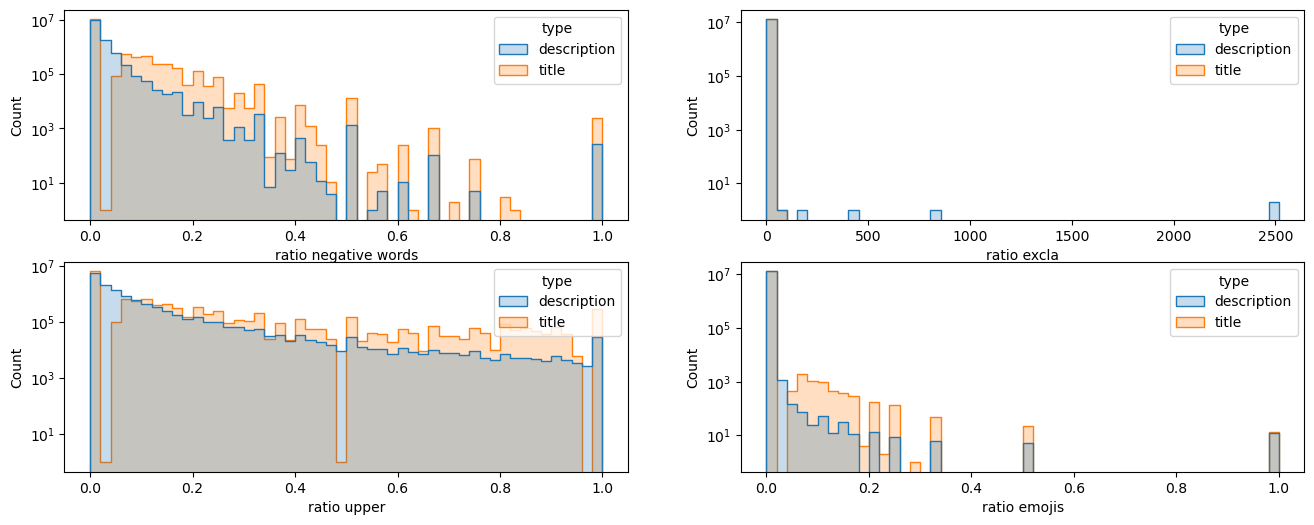

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,6))

sns.histplot(df_hist, x="ratio negative words", bins=50, hue="type", element="step", ax=axes[0, 0])
sns.histplot(df_hist, x="ratio excla", bins=50, hue="type", element="step", ax=axes[0, 1])
sns.histplot(df_hist, x="ratio upper", bins=50, hue="type", element="step", ax=axes[1, 0])
sns.histplot(df_hist, x="ratio emojis", bins=50, hue="type", element="step", ax=axes[1, 1])
axes[0, 0].set(yscale ='log')
axes[0, 1].set(yscale ='log')
axes[1, 0].set(yscale ='log')
axes[1, 1].set(yscale ='log')
plt.show()

[None]

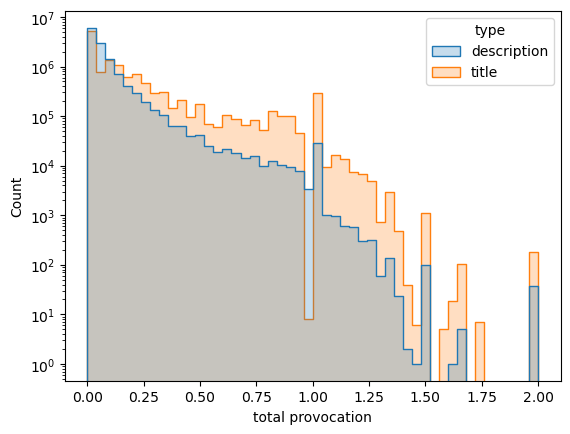

In [51]:
sns.histplot(df_hist, x="total provocation", bins=50, hue="type", element="step").set(yscale ='log')
